# data analysis of convergence thresholds

**Reason** : convergence can be very slow. If errors are minor, maximum number of convergence loops can be used to speed up PLCCA execution.

**What we look at** : 

   * weights
   * correlations
   * residual error
   * time-execution
   * financial performance metrics

# Data and libraries

**naming convention :**

c100_10 : 100 assets, maximum 10 loops

c100_100 : 100 assets, maximum 100 loops

*max loops is over each of the following : outer loop, primal weights convergence, dual weights convergence*

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib.pyplot as pl
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error


In [21]:
c100_10 = pd.read_csv('convergence_100_10.csv')
c100_100 = pd.read_csv('convergence_100_100.csv')
c100_1000 = pd.read_csv('convergence_100_1000.csv')

c50_10 = pd.read_csv('convergence_50_10.csv')
c50_100 = pd.read_csv('convergence_50_100.csv')
c50_1000 = pd.read_csv('convergence_50_1000.csv') 

c10_10 = pd.read_csv('convergence_10_10.csv')
c10_100 = pd.read_csv('convergence_10_100.csv')
c10_1000 = pd.read_csv('convergence_10_1000.csv')


# Preprocessing

In [22]:
def string_to_num(string):
    string = string.replace("\n","")
    string = string.replace("[","")
    string = string.replace("]","")
    string = string.split(" ")
    lst = [s for s in string if s]
    lst = list(map(float,lst))
    return np.array(lst)
def df_str_to_num(df,cols=["weights","cor","res","time_outer","time_w", "time_e"]):
    opt = pd.DataFrame(columns=cols)
    for col in cols:
        #print(col)
        for i in range(df.shape[0]):
            #print(string_to_num(df.loc[i,col]))
            #print(string_to_num(df.loc[i,col]))
            opt.loc[i,col] = string_to_num(df.loc[i,col])
    df[cols] = opt
    return df
    

In [23]:
all_df = [c100_10,c100_100,c100_1000,c50_10,c50_100,c50_1000,c10_10,c10_100,c10_1000]
df_names=["c100_10","c100_100","c100_1000","c50_10","c50_100","c50_1000","c10_10","c10_100","c10_1000"]
df_assets = [100,100,100,50,50,50,10,10,10]
for df in all_df:
    df = df_str_to_num(df)
    df.pop("Unnamed: 0")

# Weights analysis

For each portfolio size, i.e. 100, 50, and 10 assets we evaluate the difference in weights that are obtained when we force convergence to stop after 10, 100, or 1000 iterations.

We start by looking at weights overall, raw and normalized. More specifically, we evaluate the mean absolute percentage error of raw weights and mean absolute error of normalized weights.

In [27]:
weights_convergence = pd.DataFrame(columns=["raw_mape","normalized_mae"])
c = 0
for df1 in all_df:
    for df2 in all_df[c:]:
        if df1["weights"][0][0] != df2["weights"][0][0] and df1["weights"][0].shape == df2["weights"][0].shape:
            weights_convergence.loc[c,"raw_mape"] = np.mean([mean_absolute_percentage_error(df1["weights"][i],df2["weights"][i])
                                                             for i in range(len(df1["weights"]))])
            weights_convergence.loc[c,"normalized_mae"] = np.mean([mean_absolute_error(df1["weights"][i]/np.linalg.norm(df1["weights"][i]),
                                                   df2["weights"][i]/np.linalg.norm(df2["weights"][i]))
                                                                   for i in range(len(df1["weights"]))])
            
            c+=1


In [28]:
idx = ["10_vs_100","10_vs_1000","100_vs_1000"]*3
weights_convergence = weights_convergence.drop_duplicates()
weights_convergence.index = idx

In [29]:
# cumulative weights, though
weights_convergence

,raw_mape,normalized_mae
10_vs_100,4.727182,0.0966
10_vs_1000,17.588302,0.108133
100_vs_1000,417.932504,0.109103
10_vs_100,3.581715,0.118381
10_vs_1000,4.104856,0.117515
100_vs_1000,4.35546,0.108768
10_vs_100,2.696838,0.215231
10_vs_1000,3.472012,0.201137
100_vs_1000,1.761816,0.170908


# Correlations analysis

In [33]:
cor_convergence = pd.DataFrame(columns=["cor_mae"])
c = 0
for df1 in all_df:
    for df2 in all_df:
        if df1["weights"][0][0] != df2["weights"][0][0] and df1["weights"][0].shape == df2["weights"][0].shape:
            cor_convergence.loc[c,"cor_mae"] = np.mean([mean_absolute_error(df1["cor"][i],df2["cor"][i]) for i in range(len(df1["cor"]))])
            c+=1


In [34]:
cor_convergence = cor_convergence.drop_duplicates()
cor_convergence.index = idx

In [35]:
cor_convergence.T

,10_vs_100,10_vs_1000,100_vs_1000,10_vs_100,10_vs_1000,100_vs_1000,10_vs_100,10_vs_1000,100_vs_1000
cor_mae,0.059674,0.078812,0.079427,0.052891,0.053716,0.039591,0.040521,0.038602,0.031482


In [95]:
# evolution of difference in correlations once we move further into the canonical portfolios
mean_diff_corr = np.full((100,18), np.nan)
co = 0
for df1 in all_df:
    for df2 in all_df[co:]:
        if df1["weights"][0][0] != df2["weights"][0][0] and df1["weights"][0].shape == df2["weights"][0].shape:
            for i in range(len(df1["weights"][0])):
                a = np.array([df1.loc[j,"cor"][i] for j in range(100)])
                b = np.array([df2.loc[j,"cor"][i] for j in range(100)])
                s = mean_absolute_error(a,b)
                z = np.mean(abs(a-b))
                mean_diff_corr[i,co] = s
            
            # next col
            co += 1

In [96]:
mean_diff_corr = pd.DataFrame(mean_diff_corr, columns = np.arange(0,18,1))
mean_diff_corr = mean_diff_corr.T.drop_duplicates().T
mean_diff_corr = mean_diff_corr.iloc[:,:-1]
mean_diff_corr.columns = idx

<AxesSubplot:>

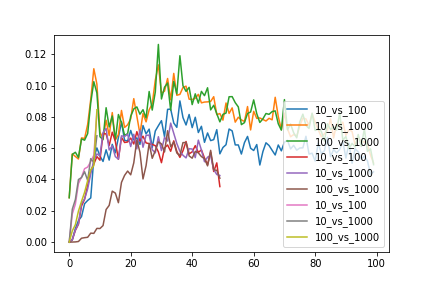

In [97]:
# plot mean difference in orthogonal portfolio correlations for different max convergences
%matplotlib widget
mean_diff_corr.plot()

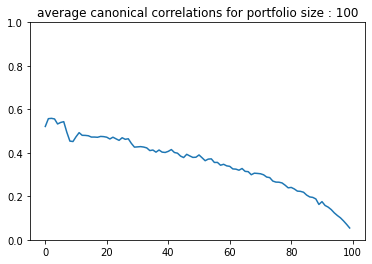

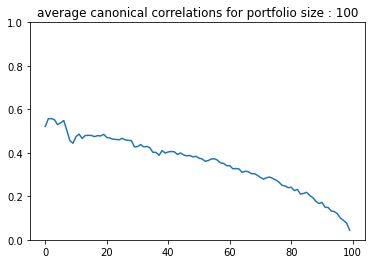

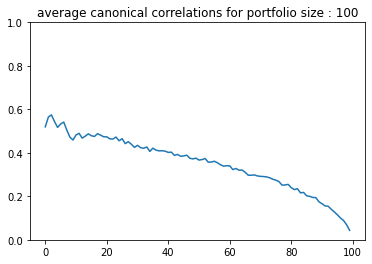

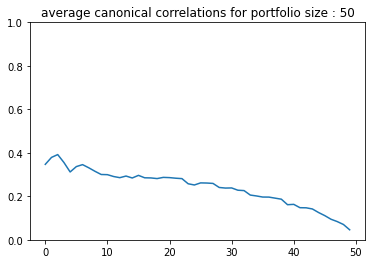

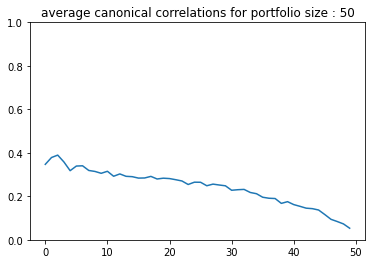

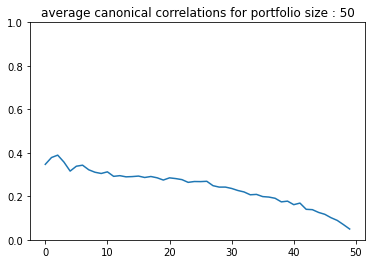

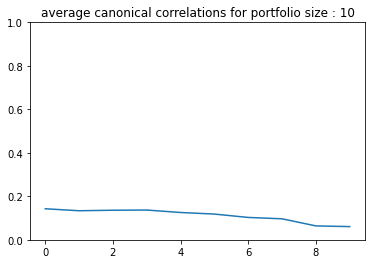

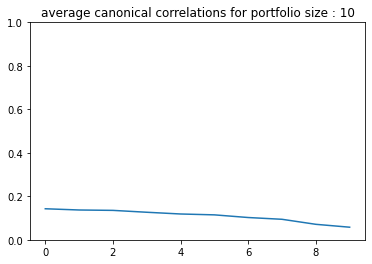

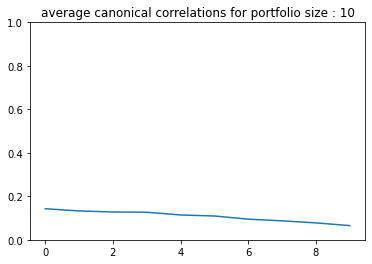

In [68]:
%matplotlib inline
for df in all_df:
    n_assets = len(df["weights"][0])
    pl.plot(df.index[:n_assets],df["cor"].mean())
    pl.ylim((0,1))
    pl.title('average canonical correlations for portfolio size : '+str(n_assets))
    pl.show()

# Residual analysis

In [98]:
res_convergence = pd.DataFrame(columns=["res_mse"])
c = 0
for df1 in all_df:
    for df2 in all_df:
        if df1["weights"][0][0] != df2["weights"][0][0] and df1["weights"][0].shape == df2["weights"][0].shape:
            res_convergence.loc[c,"res_mse"] = np.mean([mean_absolute_error(df1["res"][i],df2["res"][i]) for i in range(len(df1["res"]))])
            c+=1


In [99]:
res_convergence = res_convergence.drop_duplicates()
res_convergence.index = idx

In [71]:
res_convergence.T

,10_vs_100,10_vs_1000,100_vs_1000,10_vs_100,10_vs_1000,100_vs_1000,10_vs_100,10_vs_1000,100_vs_1000
res_mse,0.029837,0.039406,0.039713,0.026445,0.026858,0.019795,0.02026,0.019301,0.015741


In [72]:
# evolution of difference in correlations once we move further into the canonical portfolios
mean_diff_res = np.full((100,18), np.nan)
co = 0
for df1 in all_df:
    for df2 in all_df[co:]:
        if df1["weights"][0][0] != df2["weights"][0][0] and df1["weights"][0].shape == df2["weights"][0].shape:
            for i in range(len(df1["weights"][0])):
                a = np.array([df1.loc[j,"res"][i] for j in range(100)])
                b = np.array([df2.loc[j,"res"][i] for j in range(100)])
                s = mean_absolute_error(a,b)
                #z = np.mean(abs(a-b))
                z = np.mean(abs(a-b))
                mean_diff_res[i,co] = s
            
            # next col
            co += 1

In [73]:
mean_diff_res = pd.DataFrame(mean_diff_res, columns = np.arange(0,18,1))
mean_diff_res = mean_diff_res.T.drop_duplicates().T
mean_diff_res = mean_diff_res.iloc[:,:-1]
mean_diff_res.columns = idx

<AxesSubplot:>

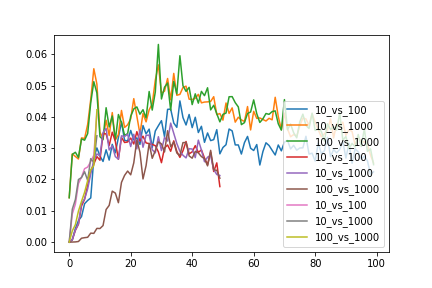

In [75]:
# plot mean difference in orthogonal portfolios residuals for different max convergences
%matplotlib widget
mean_diff_res.plot()

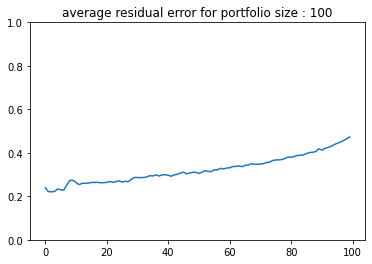

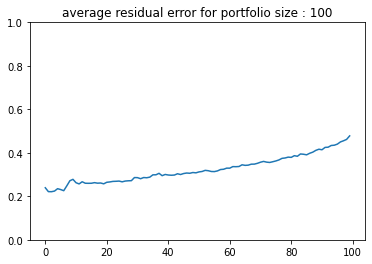

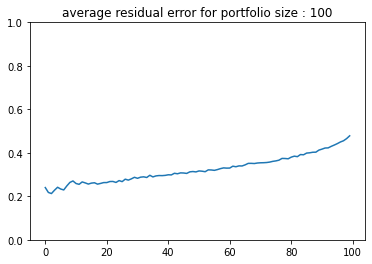

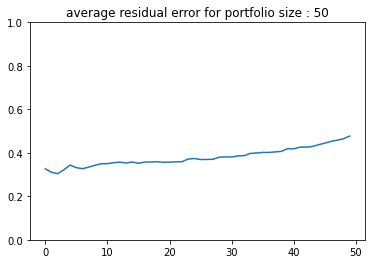

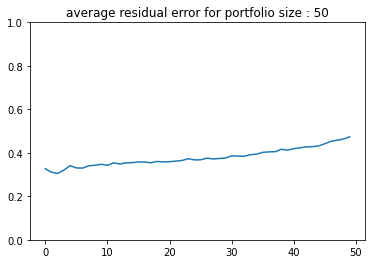

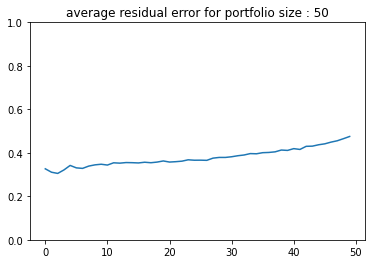

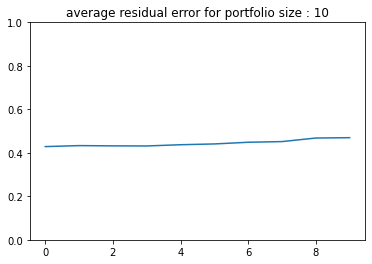

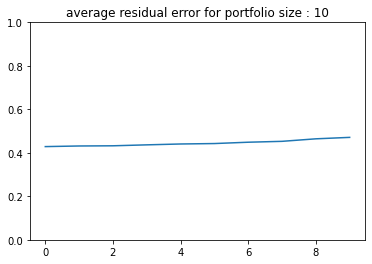

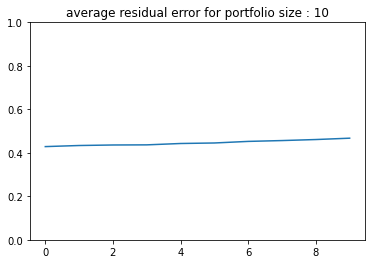

In [77]:
%matplotlib inline
for df in all_df:
    n_assets = len(df["weights"][0])
    pl.plot(df.index[:n_assets],df["res"].mean())
    pl.ylim((0,1))
    pl.title('average residual error for portfolio size : '+str(n_assets))
    pl.show()

# time execution

## outer loop

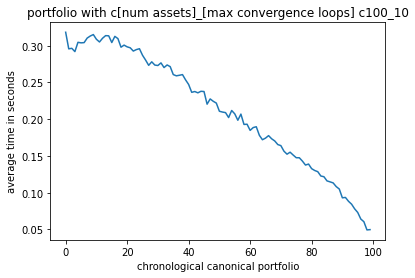

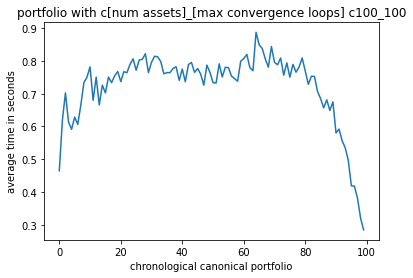

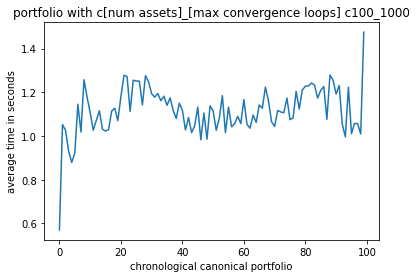

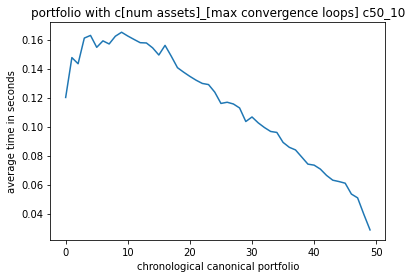

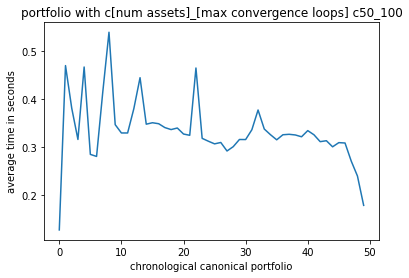

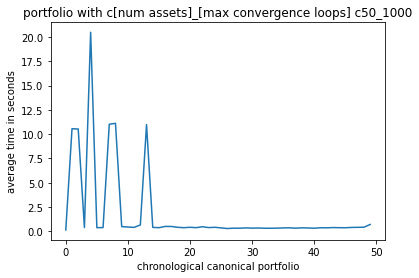

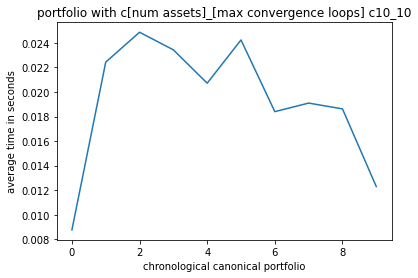

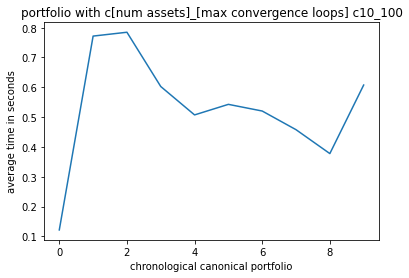

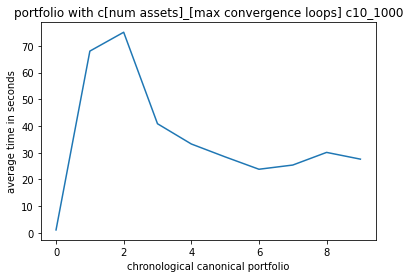

In [135]:
# check convergence time as we try to find more canonical portfolios
%matplotlib inline
for i in range(len(all_df)):
    pl.plot(all_df[i].index[:df_assets[i]], all_df[i]["time_w"].mean())
    pl.title("portfolio with c[num assets]_[max convergence loops] "+df_names[i])
    pl.ylabel("average time in seconds")
    pl.xlabel("chronological canonical portfolio")
    pl.show()

In [78]:
# evolution of difference in outer loop time once we move further into the canonical portfolios
mean_diff_to = np.full((100,18), np.nan)
co = 0
for df1 in all_df:
    for df2 in all_df[co:]:
        if df1["weights"][0][0] != df2["weights"][0][0] and df1["weights"][0].shape == df2["weights"][0].shape:
            for i in range(len(df1["weights"][0])):
                a = np.array([df1.loc[j,"time_outer"][i] for j in range(100)])
                b = np.array([df2.loc[j,"time_outer"][i] for j in range(100)])
                #print(a/b)
                s = np.mean(a/b)
                #z = np.mean(abs(a-b))
                z = np.mean(abs(a-b))
                mean_diff_to[i,co] = s
            
            # next col
            co += 1

In [79]:
mean_diff_to = pd.DataFrame(mean_diff_to, columns = np.arange(0,18,1))
mean_diff_to = mean_diff_to.T.drop_duplicates().T
mean_diff_to = mean_diff_to.iloc[:,:-1]
mean_diff_to.columns = idx

<AxesSubplot:>

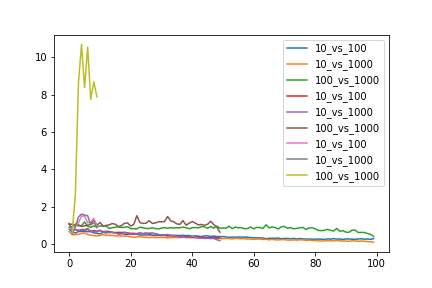

In [80]:
# plot ratio of convergence time in orthogonal portfolios outer loop time as we move through canonical portfolios
%matplotlib widget
mean_diff_to.plot()

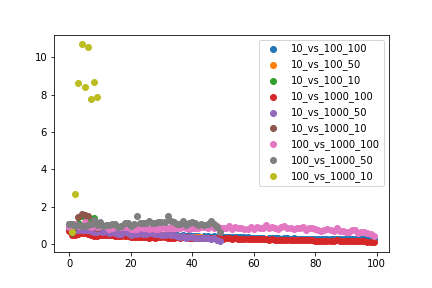

In [84]:
import matplotlib.pyplot as plt
%matplotlib widget
#%matplotlib inline
for tp in ["10_vs_100","10_vs_1000","100_vs_1000"]:
    for i in range(3):
        if i == 0:
            lab = tp + "_100"
        elif i == 1:
            lab = tp + "_50"
        else:
            lab = tp + "_10"
        plt.scatter(mean_diff_to.index,mean_diff_to[tp].iloc[:,i],label=lab)
        plt.legend()

## Primal weights loop

In [81]:
# evolution of difference in outer loop time once we move further into the canonical portfolios
mean_diff_tw = np.full((100,18), np.nan)
co = 0
for df1 in all_df:
    for df2 in all_df[co:]:
        if df1["weights"][0][0] != df2["weights"][0][0] and df1["weights"][0].shape == df2["weights"][0].shape:
            for i in range(len(df1["weights"][0])):
                a = np.array([df1.loc[j,"time_w"][i] for j in range(100)])
                b = np.array([df2.loc[j,"time_w"][i] for j in range(100)])
                s = np.mean(a/b)
                #z = np.mean(abs(a-b))
                z = np.mean(abs(a-b))
                mean_diff_tw[i,co] = s
            
            # next col
            co += 1

In [85]:
mean_diff_tw = pd.DataFrame(mean_diff_tw, columns = np.arange(0,18,1))
mean_diff_tw = mean_diff_tw.T.drop_duplicates().T
mean_diff_tw = mean_diff_tw.iloc[:,:-1]
mean_diff_tw.columns = idx

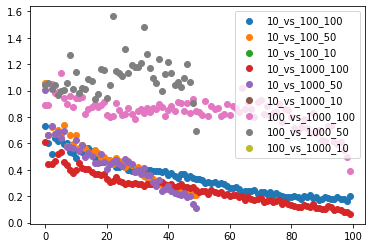

In [86]:
%matplotlib inline
for tp in ["10_vs_100","10_vs_1000","100_vs_1000"]:
    for i in range(3):
        if i == 0:
            lab = tp + "_100"
        elif i == 1:
            lab = tp + "_50"
        else:
            lab = tp + "_10"
        plt.scatter(mean_diff_tw.index,mean_diff_tw[tp].iloc[:,i],label=lab)
        plt.legend()


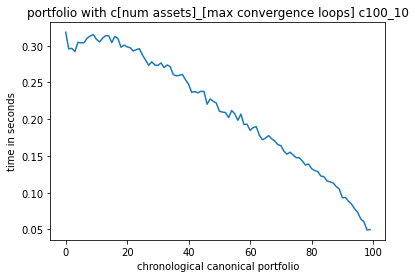

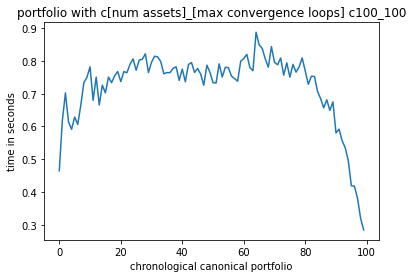

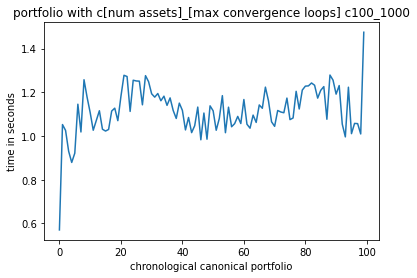

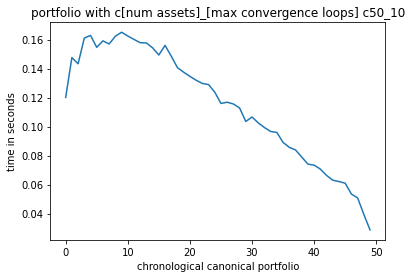

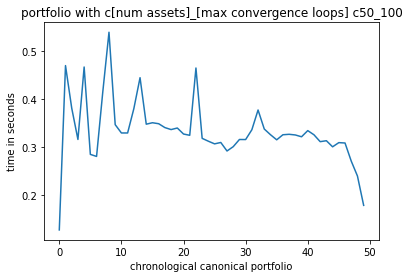

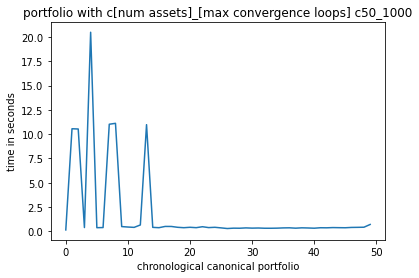

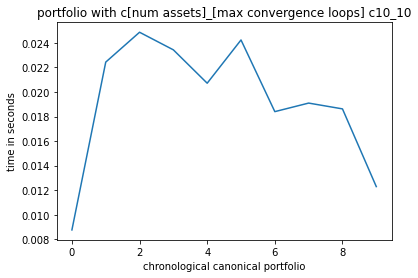

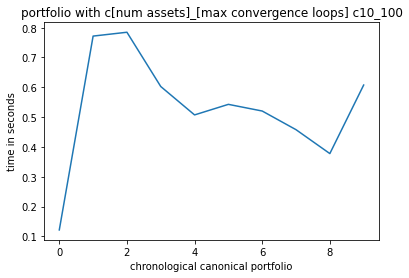

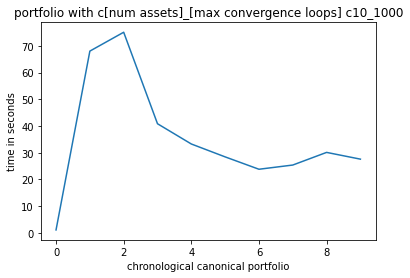

In [136]:
%matplotlib inline
for i in range(len(all_df)):
    pl.plot(all_df[i].index[:df_assets[i]], all_df[i]["time_w"].mean())
    pl.title("portfolio with c[num assets]_[max convergence loops] "+df_names[i])
    pl.ylabel("time in seconds")
    pl.xlabel("chronological canonical portfolio")
    pl.show()

## Dual weights loop

In [101]:
# evolution of difference in outer loop time once we move further into the canonical portfolios
mean_diff_te = np.full((100,18), np.nan)
co = 0
for df1 in all_df:
    for df2 in all_df[co:]:
        if df1["weights"][0][0] != df2["weights"][0][0] and df1["weights"][0].shape == df2["weights"][0].shape:
            for i in range(len(df1["weights"][0])):
                a = np.array([df1.loc[j,"time_e"][i] for j in range(100)])
                b = np.array([df2.loc[j,"time_e"][i] for j in range(100)])
                #print(a/b)
                s = np.where(a/b==np.Inf,0,a/b)
                s = np.nanmean(s)
                #z = np.mean(abs(a-b))
                z = np.mean(abs(a-b))
                mean_diff_te[i,co] = s         
            # next col
            co += 1

In [102]:
mean_diff_te = pd.DataFrame(mean_diff_te, columns = np.arange(0,18,1))
mean_diff_te = mean_diff_te.T.drop_duplicates().T
mean_diff_te = mean_diff_te.iloc[:,:-1]
mean_diff_te.columns = idx

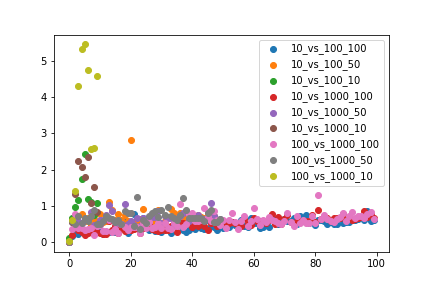

In [104]:
%matplotlib widget
for tp in ["10_vs_100","10_vs_1000","100_vs_1000"]:
    for i in range(3):
        if i == 0:
            lab = tp + "_100"
        elif i == 1:
            lab = tp + "_50"
        else:
            lab = tp + "_10"
        plt.scatter(mean_diff_te.index,mean_diff_te[tp].iloc[:,i],label=lab)
        plt.legend()


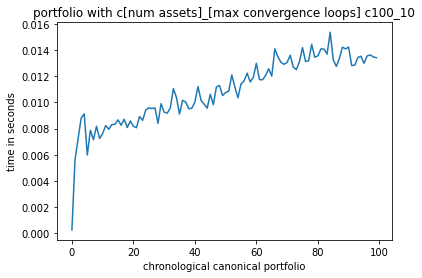

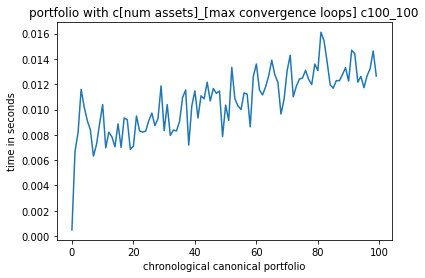

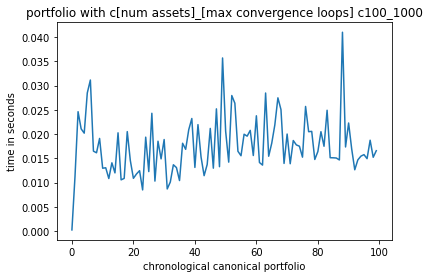

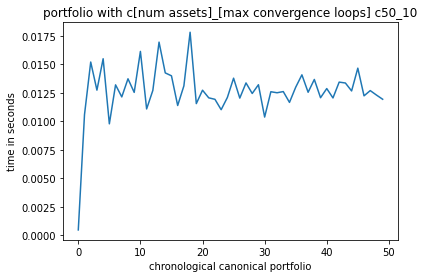

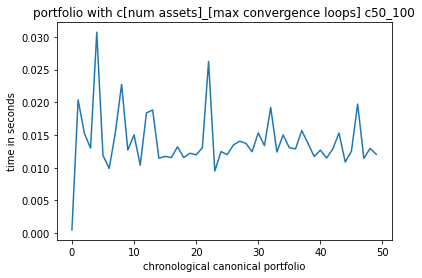

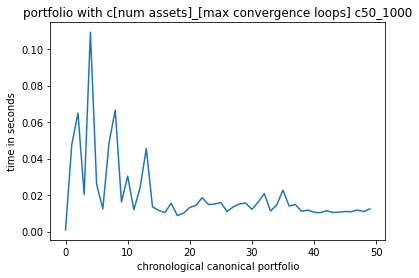

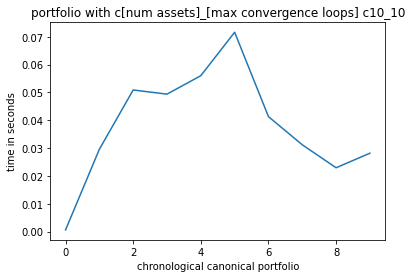

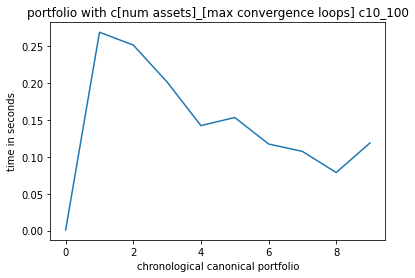

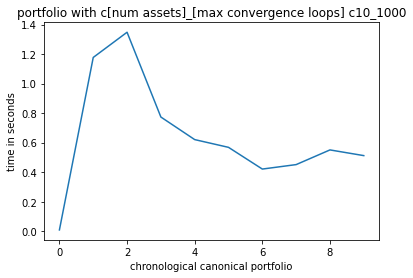

In [137]:
%matplotlib inline
for i in range(len(all_df)):
    pl.plot(all_df[i].index[:df_assets[i]], all_df[i]["time_e"].mean())
    pl.title("portfolio with c[num assets]_[max convergence loops] "+df_names[i])
    pl.ylabel("time in seconds")
    pl.xlabel("chronological canonical portfolio")
    pl.show()

# Financial performance

In [ ]:
import os
import sys
import pickle

HOME_DIRECTORY = 'C:/Users/Harol/OneDrive/Documents/master computational finance/thesis/thesis_UCL/Code/convergence'
sys.path.append(HOME_DIRECTORY)

from project_lib.utils import *
from project_lib.performance import *
from project_lib.analysis import *
from project_lib.portfolio import Portfolio


# Show multiple outputs
plt.style.use('seaborn-ticks')
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams["figure.figsize"] = [6.4,4.8]
plt.rc("figure", figsize=(30,10))
plt.rc("font", size=25)
plt.rc("lines", linewidth=1)
plt.rcParams['mathtext.fontset'] = 'custom'

# Import the necessaries libraries
import plotly.offline as pyo
# Set notebook mode to work in offline
pyo.init_notebook_mode()

pd.options.plotting.backend = "plotly"



In [ ]:
with open(HOME_DIRECTORY + '/data/processed_daily_data/ret_subset.pkl', 'rb') as f:
    ret = pickle.load(f)

In [ ]:
# take data and then set indices of weights and make prices and then check the performance metrics
universe_size = 200
ret = ret.iloc[:400, :universe_size]  # subset the data

In [ ]:
ret = ret.iloc[4:,:]
ret = ret.iloc[250:350,:]

In [ ]:
prices = (1 + ret).cumprod()
prices = prices.iloc[:,:universe_size]

In [ ]:
plcca.index = ret.iloc[252:,:].index
# set plcca columns to return df columns
cov_models=["sample"]
plcca_weights = {m: pd.DataFrame(columns=plcca.columns) for m in cov_models}
plcca_weights["sample"] = plcca.copy()